# <span style="color:red">Deep Learning Project: Music Playlist Generation based on Spotify Playlists</span>

This project was realized by Alexandre Felix and Jérémy Houdé for the Deep Learning lesson in SoSe 2023. The goal of the project was to automatically generate playlists, based on the [Spotify Millon Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). With one or multiple songs, the method should be able to append new relevant songs to the initial playlist.

For this project following folders are required in the current folder:
- `./data`
- `./models`

Please place `spotify_million_playlist_dataset.zip` in the folder `./data` or adapt the cells when loading or storing the data. Python will maybe itself create missing folders without any error.

## <span style="color:green">Overview</span>
 - Spotify Millon Playlist Dataset: load and process data
 - Definition of two baseline methods: random and with use of tracks occurences
 - Training a Gensim's Word2Vec model as simple track embedding
 - Training 2 recurent neural networks (RNN): one with mean squared error and the other with cosine similarity as loss function
 - Evaluation of all methods with 3 defined tests
 - Small user study for the evaluating the track embedding and two RNNs
 - Conclusion

## <span style="color:green">Spotify Million Playlist Dataset</span>

The Spotify dataset contains one million user-generated playlists with over 2 million unique tracks by nearly 300,000 artists. These playlists were created by US Spotify users between January 2010 and November 2017. The dataset is stored in a ZIP file, in which data were splitted in multiple json slices. Each json file contains exactly 1,000 playlists and are named with following convention: ``mpd.slice.{start_playlist_ID}-{end_playlist_ID}.json``.

### Data to keep

Stored data has following structure for each json slice/file:
```json
{
    'info': { ... },
    'playlists': [
            {
            "name": "musical",
            "collaborative": "false",
            "pid": 5,
            "modified_at": 1493424000,
            "num_albums": 7,
            "num_tracks": 12,
            "num_followers": 1,
            "num_edits": 2,
            "duration_ms": 2657366,
            "num_artists": 6,
            "tracks": [
                {
                    "pos": 0,
                    "artist_name": "Degiheugi",
                    "track_uri": "spotify:track:7vqa3sDmtEaVJ2gcvxtRID",
                    "artist_uri": "spotify:artist:3V2paBXEoZIAhfZRJmo2jL",
                    "track_name": "Finalement",
                    "album_uri": "spotify:album:2KrRMJ9z7Xjoz1Az4O6UML",
                    "duration_ms": 166264,
                    "album_name": "Dancing Chords and Fireflies"
                }
            ]
        }
    ]
}
```

By extrating the data, we will only be insteressed by the playlists values and folloving tracks values:
```json
{
    'playlists': [
        {
            "num_tracks": 12,
            "duration_ms": 2657366,
            "tracks": [
                {
                    "track_uri": "spotify:track:7vqa3sDmtEaVJ2gcvxtRID",
                    "artist_uri": "spotify:artist:3V2paBXEoZIAhfZRJmo2jL",
                    "album_uri": "spotify:album:2KrRMJ9z7Xjoz1Az4O6UML",
                    "duration_ms": 166264
                }
            ]
        }
    ]
}
```
- We consider the artist_uri, album_uri, and the song duration as important data for each track.
- Unfortunately, the genre wasn't stored in the initial database, but we make the assuption that some tracks in the playlists could have a common genre or musique style.

### Load data

The unziped data weigth more than 40 GB. Because of RAM or vRAM limitations, we will only use a subset for our experiments. The selected subset will only contain the first **20,000** playlists, contained in the first 20 files. We have firstly attempted to load 200, 150, and 50 files, but either to much RAM was needed or evaluatition of `get_next_song` was too long: 5 days for 20% of 150,000 paylists and 14 hours for 20% of 50,000 playlists with playlists_max_len = 5. So we will use only the first 20,000 playlists and playlists_max_len = 10 for computing k grams. We ran this notebook locally, as the free access for Google Colab hadn't enougth RAM.

We will store the first 20,000 playlists in one dataframe and after that all unique tracks in a second dataframe. Two dataframes will be usefull in this notebook.

We will now extract the first 20,000 playlists and fit it into a pandas dataframe and keep folling data:

In [2]:
import pandas as pd
import json
import fnmatch
from tqdm import tqdm
from zipfile import ZipFile

def load_zip_data(zip_file: str, number_of_files: int) -> list[dict]:
    """Load a specified number of json files from a zip file and return a list of collected playlists."""
    with ZipFile(zip_file) as zipfiles: # open ZIP file
        file_list = zipfiles.namelist()

        json_files = fnmatch.filter(file_list, "*.json")
        json_files = [file for index,file in sorted([(int(filename.split('.')[2].split('-')[0]), filename) for filename in json_files])]
        playlists: list[dict] = []

        for filename in tqdm(json_files[:number_of_files]): # for each json file
            with zipfiles.open(filename) as json_file:
                current_slice = json.loads(json_file.read())
                playlists.extend(current_slice['playlists']) # add new playlists

        return playlists

zip_file = 'data/spotify_million_playlist_dataset.zip'
playlists_dict = load_zip_data(zip_file, 20)

playlists = pd.DataFrame(playlists_dict, columns = ["tracks", "num_tracks", "duration_ms"])

100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


We remove now the unnecessary data in each track. We only keep as IDs the uris and we make the assuption that the duration is an important factor for the conception of a playlist.

In [3]:
# remove from tracks not needed information
for tracks in playlists['tracks']:
    for track in tracks:
        del track['pos']
        del track['artist_name']
        del track['track_name']
        del track['album_name']

#### Collecting the 20,000 first playlists

In [4]:
playlists

,tracks,num_tracks,duration_ms
0,[{'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDO...,52,11532414
1,[{'track_uri': 'spotify:track:2HHtWyy5CgaQbC7X...,39,11656470
2,[{'track_uri': 'spotify:track:74tqql9zP6JjF5hj...,64,14039958
3,[{'track_uri': 'spotify:track:4WJ7UMD4i6DOPzyX...,126,28926058
4,[{'track_uri': 'spotify:track:4iCGSi1RonREsPtf...,17,4335282
...,...,...,...
19995,[{'track_uri': 'spotify:track:64j3Bd62HTe0pclk...,18,4614171
19996,[{'track_uri': 'spotify:track:09OojFvtrM9YRzRj...,24,4675554
19997,[{'track_uri': 'spotify:track:4lNznSUjByH5zWpP...,106,28912970
19998,[{'track_uri': 'spotify:track:1yy2DlSDtEt90d54...,36,9374114


#### Collecting unique tracks

We will store all tracks in a separate DataFrame. This will be usefull later for track embeddings and for the random base line method `get_next_random_song`.

In [5]:
tracks = pd.json_normalize(playlists_dict, record_path=['tracks'])
tracks.drop_duplicates(inplace=True, ignore_index=True)

# free RAM
del playlists_dict

tracks

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
...,...,...,...,...
263464,spotify:track:2MQ9NWMZfi0qPUhDR6sRCL,spotify:artist:278ZYwGhdK6QTzE3MFePnP,spotify:album:0kIXzVzbFuUf5kxM8US67m,297053
263465,spotify:track:4eOptezifAi7VpOoz9lu4r,spotify:artist:2ye2Wgw4gimLv2eAKyk1NB,spotify:album:6VeUJmkLCGWRiF8j6RrIEx,301293
263466,spotify:track:2FvIkVNVEmiAaasafDSWSV,spotify:artist:6PWU6JQvvYv5sz5FOODHg6,spotify:album:2rkBQR8GIeP8XlEYrp6DsM,250506
263467,spotify:track:48ifRcXHbUjc1moUjJcwhx,spotify:artist:6UfoTQXaV3DuqtDVjZIxwZ,spotify:album:1p5T4GozRHLUxtaLN46sLz,319760


Check if duplicates are removed:

In [6]:
song = tracks.loc[tracks['track_uri'] == 'spotify:track:2jFlMILIQzs7lSFudG9lbo']
song

,track_uri,artist_uri,album_uri,duration_ms
40,spotify:track:2jFlMILIQzs7lSFudG9lbo,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,spotify:album:0ylxpXE00fVxh6d60tevT8,229360


#### Save or reload data

In [1]:
# exec on every opening
tracks_filename = 'data/tracks.json'
playlists_filename = 'data/playlists.json'

Save data as json files:

In [8]:
playlists.to_json(playlists_filename)
tracks.to_json(tracks_filename)

Tracks and playlists only need to be processed once. When needed, reload processed tracks and playlists from json files:

In [2]:
# exec on every opening
import pandas as pd

tracks = pd.read_json(tracks_filename)
playlists = pd.read_json(playlists_filename)

## <span style="color:green">Defining baseline methods</span>

before looking to the architecture of the neural network, we will first define two baseline methods to compare against.
These methods should get as an input k track uris and return a possible next song, that could work with the initial playlist.

We will rapidly test two baseline methods in this section on some playlist and analyse the result. We will later evaluated these baseline methods with all other methods by using k-gramm and analysing the playlist generation problem as a binary problem. There will be several evaluation cases.

### Random baseline

the random baseline takes one random song from the tracks list:

In [3]:
# exec on every opening

def get_random_next_song(song_uris: list[str]) -> str:
    """return a random song. Could be a song that already occurs in song_uri"""
    return tracks['track_uri'].sample().iloc[0]

We execute the method with the first 3 tracks from the first playlist:

In [4]:
## URIs of the first 3 songs from playlist 1:
song_uris = [song['track_uri'] for song in playlists.iloc[0]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_random_next_song(song_uris)
    song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv']
New playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:5vuTGTSFamDHDJuTxUKJWG', 'spotify:track:5Mpj0LRFQsrKjUIP2sRqTw', 'spotify:track:6u3OatqyTB6gY8xbkSL50y', 'spotify:track:2Ae5awwKvQpTBKQHr1TYCg', 'spotify:track:18bjraoIs57fzdy29tl3bG']


In [5]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
14856,spotify:track:6u3OatqyTB6gY8xbkSL50y,spotify:artist:3CGuwWgoCYSO5Z72H5G2Ec,spotify:album:791YOj0Yz76nrTtTbhGHeC,182069
23649,spotify:track:2Ae5awwKvQpTBKQHr1TYCg,spotify:artist:4PVn1b2WnnXdq80C7uaZLZ,spotify:album:1B0jux6nCrSuez1iPS7tUJ,195428
71334,spotify:track:5vuTGTSFamDHDJuTxUKJWG,spotify:artist:3aWnyANApsrS1yIpPu873P,spotify:album:4p51bZU1pOLk5Pkw83vyPA,157013
88356,spotify:track:18bjraoIs57fzdy29tl3bG,spotify:artist:7Gf3LSwa5hh8Cjo60WhVjC,spotify:album:1F9Fd7d8U3wykniDos7pbg,225506
157018,spotify:track:5Mpj0LRFQsrKjUIP2sRqTw,spotify:artist:4dUdNvFt1PhzClTKLIT83u,spotify:album:6shGyOMELm9BZl4wxKxmhX,508533


In [6]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[0]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 1 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (2, 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv')]

This method is fast, but we don't expect a song that maches perfectly the input playlist. These songs possibely not occur in a playlist together like here and there have not necessary similarities together like a common artist or album. As the returned track is fully random, this method will a lower bound to stike. Our developped methods should be at least better that this random generator.

### Get next song based on the previous k songs with tracks occurrences

This method will analyse every playlist and find a song that mostly occurs with the k previous songs. In this method the order matters and only songs placed after the input songs will be retourned. Moreover, The order of input songs also matters, that's why it could be possible that this method may sometimes not return or find a next song.

This method is far slower than the first one, but we expect that its only return relevant songs, when they exist. We tried to improve the readibility with apply and map to filter the relevant playlists, but the optimized version was 2 times slower than this one.

In [4]:
# exec on every opening
import pandas as pd

def get_next_song(song_uris: list[str]) -> str | None:
    """select the song that appears in together in the largest number of playlists with the previous songs."""
    song_occurrences: dict[str, int] = {}
        
    for tracks in playlists['tracks']:
        track_uris = [track['track_uri'] for track in tracks]
        
        if not all(song in track_uris for song in song_uris): # check if every songs are contained
            continue
            
        songs_count = 0
        
        for track_uri in track_uris:
            if (songs_count < len(song_uris) and
                track_uri == song_uris[songs_count]):
                songs_count += 1
                continue
            if songs_count < len(song_uris) or track_uri in song_uris:
                continue
            
            # current track_uri is not in song_uris and occurs after the k previous songs
            if track_uri in song_occurrences.keys():
                song_occurrences[track_uri] += 1
            else:
                song_occurrences[track_uri] = 1
    next_songs = [ track_uri for (track_uri, _n) in sorted(song_occurrences.items(), key=lambda x:x[1], reverse=True)] # sort by playlist count desc
    
    return next_songs[0] if len(next_songs) > 0 else None # may not found a next song

# method to analyse the occurences of a particular song in the playlists
def song_occurrence(song_uri: str, playlists: pd.DataFrame) -> int:
    """Return occurrence of one song in the playlists"""
    song_occurrence = 0
        
    for tracks in playlists['tracks']:
        track_uris = [track['track_uri'] for track in tracks]
        
        if song_uri in track_uris : # check if every songs are contained
            song_occurrence += 1
    
    return song_occurrence

#### Test with the first 3 songs of the first two playlists:

We will now test our method with the first 3 songs from the two first playlists. We will after that check if they are from the same album, artist or contained in that order in the complete playlist.

In [8]:
## URIs of the first 3 songs from playlist 1:
song_uris = [song['track_uri'] for song in playlists.iloc[0]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv']


New playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:2gam98EZKrF9XuOkU13ApN', 'spotify:track:0uqPG793dkDDN7sCUJJIVC', 'spotify:track:6GIrIt2M39wEGwjCQjGChX', 'spotify:track:4E5P1XyAFtrjpiIxkydly4', 'spotify:track:3H1LCvO3fVsK2HPguhbml0']


In [9]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
10,spotify:track:2gam98EZKrF9XuOkU13ApN,spotify:artist:2jw70GZXlAI8QzWeY2bgRc,spotify:album:2yboV2QBcVGEhcRlYuPpDT,242293
21,spotify:track:0uqPG793dkDDN7sCUJJIVC,spotify:artist:1yxSLGMDHlW21z4YXirZDS,spotify:album:1bNyYpkDRovmErm4QeDrpJ,272533
31,spotify:track:6GIrIt2M39wEGwjCQjGChX,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,spotify:album:4WqgusSAgXkrjbXzqdBY68,206520
32,spotify:track:4E5P1XyAFtrjpiIxkydly4,spotify:artist:5tKXB9uuebKE34yowVaU3C,spotify:album:44hyrGuZKAvITbmrlhryf8,182306
33,spotify:track:3H1LCvO3fVsK2HPguhbml0,spotify:artist:7bXgB6jMjp9ATFy66eO08Z,spotify:album:1UtE4zAlSE2TlKmTFgrTg5,277106


In [10]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[0]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist))  # songs in playlist 1 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (2, 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv'),
 (10, 'spotify:track:2gam98EZKrF9XuOkU13ApN'),
 (21, 'spotify:track:0uqPG793dkDDN7sCUJJIVC'),
 (31, 'spotify:track:6GIrIt2M39wEGwjCQjGChX'),
 (32, 'spotify:track:4E5P1XyAFtrjpiIxkydly4'),
 (33, 'spotify:track:3H1LCvO3fVsK2HPguhbml0'),
 (51, 'spotify:track:6GIrIt2M39wEGwjCQjGChX')]

In [11]:
for song_uri in song_uris:
    print(f'Song: {song_uri}, occurrence: {song_occurrence(song_uri, playlists)}')

Song: spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, occurrence: 136
Song: spotify:track:6I9VzXrHxO9rA9A5euc8Ak, occurrence: 249
Song: spotify:track:0WqIKmW4BTrj3eJFmnCKMv, occurrence: 350
Song: spotify:track:2gam98EZKrF9XuOkU13ApN, occurrence: 331
Song: spotify:track:0uqPG793dkDDN7sCUJJIVC, occurrence: 179
Song: spotify:track:6GIrIt2M39wEGwjCQjGChX, occurrence: 99
Song: spotify:track:4E5P1XyAFtrjpiIxkydly4, occurrence: 238
Song: spotify:track:3H1LCvO3fVsK2HPguhbml0, occurrence: 177


All 8 songs aren't from the same artists or album, but seems to occur often togerther in the 20,000 playlists. 5 nexts songs aren't exactly the 5 next songs in playlist one, but they are indeed contained in the same order in playlist one.

We now repeat it with the second playlist, before analysing the final playlist.

In [12]:
## URIs of the first 3 songs from playlist 2:
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][:3]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR']
New playlist: ['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em', 'spotify:track:1NXTEkIeRL59NK61QuhYUl', 'spotify:track:3RGlJJFkWEavxeRQr9ivAd', 'spotify:track:0e9hR1vTrzlUvFH5PgA9rY', 'spotify:track:7dkbEHIMLoeuG4zXGmzhEH']


In [13]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
51,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,spotify:artist:26bcq2nyj5GB7uRr558iQg,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
53,spotify:track:3x2mJ2bjCIU70NrH49CtYR,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
54,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
55,spotify:track:1NXTEkIeRL59NK61QuhYUl,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,214268
56,spotify:track:3RGlJJFkWEavxeRQr9ivAd,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,110219
57,spotify:track:0e9hR1vTrzlUvFH5PgA9rY,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:60wUpRwDRF1jmViHaW2yu4,207520
58,spotify:track:7dkbEHIMLoeuG4zXGmzhEH,spotify:artist:6BKWwLs98ZY3ifhCDNGvLk,spotify:album:38tJMNu2lPatR7xnPchOOB,226000


In [14]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[1]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(0, 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e'),
 (1, 'spotify:track:1MYYt7h6amcrauCOoso3Gx'),
 (2, 'spotify:track:3x2mJ2bjCIU70NrH49CtYR'),
 (3, 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em'),
 (4, 'spotify:track:1NXTEkIeRL59NK61QuhYUl'),
 (5, 'spotify:track:3RGlJJFkWEavxeRQr9ivAd'),
 (6, 'spotify:track:0e9hR1vTrzlUvFH5PgA9rY'),
 (7, 'spotify:track:7dkbEHIMLoeuG4zXGmzhEH')]

In [15]:
for song_uri in song_uris:
    print(f'Song: {song_uri}, occurrence: {song_occurrence(song_uri, playlists)}')

Song: spotify:track:2HHtWyy5CgaQbC7XSoOb0e, occurrence: 271
Song: spotify:track:1MYYt7h6amcrauCOoso3Gx, occurrence: 1
Song: spotify:track:3x2mJ2bjCIU70NrH49CtYR, occurrence: 1
Song: spotify:track:1Pm3fq1SC6lUlNVBGZi3Em, occurrence: 1
Song: spotify:track:1NXTEkIeRL59NK61QuhYUl, occurrence: 2
Song: spotify:track:3RGlJJFkWEavxeRQr9ivAd, occurrence: 2
Song: spotify:track:0e9hR1vTrzlUvFH5PgA9rY, occurrence: 3
Song: spotify:track:7dkbEHIMLoeuG4zXGmzhEH, occurrence: 1


Even with 20,000 playlists, the nexts songs are generally the close next songs from  the initial playlist. There are not necessary songs from same artists or album. The reason is that some tracks or sequences of tracks only occur once in the playlists.

#### Drawbacks
This method has two big drawbacks. One drawback is his execution time and ressource comsuption, as it only go through the whole playlists and count every possibles tracks that occur after the defined one. Its execution time could get worst, when augmenting the amount of loaded slices of the spotify dataset.  
The sencond drawback is that the method can't always find a next relevant song for an unseen sequence of songs, like the example under with a playlist with 2 song from two playlists. Sometimes, this method could simply return None as lack of flexibility.

In [16]:
my_playlist = [song['track_uri'] for song in playlists.iloc[1]['tracks'][:2]] # 2 songs from playlist 1
my_playlist.extend([song['track_uri'] for song in playlists.iloc[0]['tracks'][:2]]) # add 2 songs from playlist 2

print(my_playlist)
new_song = get_next_song(my_playlist)

if not new_song:
    print("next song not found.")
else:
    print(f"new song: {new_song}") # should not found a track

['spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak']
next song not found.


## <span style="color:green">Defining a track embedding</span>

A one-hot-encoded vector for tracks would lead to vectors of 263.469 dimensions, which is very high. This may pose chanllegens in terms of memory usage and computational efficiency. That's why we decide firstly compute a track embedding, before designing a neural network. We will rain an embedding with 300 dimensions to better store the differences between tracks. Each dimension value will be in [-1, 1].

### Process tracks context for track embeddings

The computed embedding of tracks should use place tracks close to each other when:
- tracks are from the same playlists (we suppose that tracks in the same playlists could have the related genres)
- tracks from the same album
- tracks from the same artist

That's why we will generate as context list of tracks for each artists and for each album as additional information with the collected playlists. This new playlists of tracks uris will represent the words in a document, so that we can use word2vec from gensim. Before that, we will convert each track_uri to an unique number.

In [7]:
uri_playlists = playlists['tracks'].apply(lambda tracks: [song['track_uri'] for song in tracks])

# Group tracks by artists uri
artists_tracks = tracks.groupby('artist_uri')['track_uri'].apply(list)

# Group tracks by album uri
albums_tracks = tracks.groupby('album_uri')['track_uri'].apply(list)

# whole context
context_tracks = [
    *uri_playlists.values,
    *artists_tracks.values,
    *albums_tracks.values
]

print(len(context_tracks))

192070


A track will occur more often in the uri_playslists and only once in artists_tracks and albums_tracks, so that the occurence in the initial playlists has more inportance. We didn't found a possible improvement, which could put more weitgh on artists and albums. The relation between tracks of the same playlists could define a common genre or music style, as we suppose that songs listened together are similar or not from opposite genre or style. For example, we didn't expect a combination of track from hard rock and classic music in the same playlists. Or at least the probability of such as mix is very low.

### Tracks to number dicts

In [5]:
# exec on every opening
# dict for swiching between tracks and numbers
number2track = dict((index, track) for index, track in enumerate(tracks['track_uri'].values))
track2number = dict((track, index) for index, track in number2track.items())

### Train a Word2Vec model for our tracks

Word2Vec offers two methods: skip-gram and continuous bag of words(CBOW). We will use skip-gram, as it seems that skip-gram works well with infrequent word in the datasets ([NLP 101: Word2Vec — Skip-gram and CBOW](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314), [Google archive word2vec](https://code.google.com/archive/p/word2vec/)). The methode will learn the word embedding from the words context, which is composed of the surrounding words.
As we already saw, some songs could only occurs once in the initial first 20,000 playlists. Tracks could occur only three times: once in the 20,000 playlists, in one album and in one artirst playlist.

Based of computed track context, a track embedding will be computed with 300 dimensions and a window size of 10 for the skip-gram method. Each element of the vector will be in [-1, 1]. we choosed 300 for the vector dimension as it is a common vector size for word embeddings with 100 and 200. With 300 dimension, the model could store more details on the 263,469 collected unique tracks than with 100 or 200 dimensions.

In [9]:
from gensim.models.word2vec import Word2Vec

# convert each track to its corresponding number -> sequences for word2vec
context_tracks_numbers = [ [track2number[track_uri] for track_uri in tracks_list] for tracks_list in context_tracks]
print("Number of playlists", len(context_tracks_numbers))

# embedding dimensionality
embedding_dim = 300 

# how often does a word have to occur to be considered
min_word_count = 3 # song occurs in minimum in one playlist, exactly in one album and belongs to one artist -> min 3 times

# number of threads to use
num_workers = 6

# window size
window_size = 10 # same as playlist_max_len

# subsampling parameter for word2vec
subsampling = 1e-3

# Default -> epochs = 5
track2vec = Word2Vec(context_tracks_numbers, 
                     workers=num_workers,
                     vector_size=embedding_dim,
                     min_count=min_word_count,
                     sg=1, # 1: skip-gram, 0: CBOW
                     window=window_size,
                     sample=subsampling) # Doc2Vec, Playlists -> doc ?

del context_tracks # free RAM

Number of playlists 192070


In [160]:
print(track2vec.wv[0])

[-0.14133887  0.5298267   0.28651968  0.47651756 -0.14202411 -0.22677346
  0.2698547   0.40872636 -0.15492786 -0.2806876  -0.35138667 -0.15945789
  0.21445763 -0.05731115  0.06193082 -0.04005338  0.06229908  0.14815131
  0.11310843  0.18335369 -0.047298    0.11502164  0.28845456 -0.18344794
  0.45382944  0.07229611 -0.6300187   0.00204678 -0.04343742 -0.10978997
  0.04173832 -0.08603872 -0.11730956  0.13939425 -0.3780296   0.22514366
  0.07366553 -0.18718515 -0.28952512 -0.2965482  -0.12960166  0.11856887
  0.39645585 -0.0478606   0.08383924 -0.11731216 -0.17869456 -0.02608552
  0.05889146  0.17835684  0.04843201  0.14900203 -0.10878661  0.3417347
 -0.14003336  0.17206676 -0.10667188  0.01744606  0.06603897 -0.13215795
  0.10777326 -0.40764135  0.09345406  0.3893887  -0.04931842  0.15986289
 -0.25617284 -0.17399585 -0.18316162  0.0717347   0.18349743 -0.12290881
  0.29673544 -0.57016516 -0.08386099  0.34979522 -0.19567664 -0.034741
 -0.03663054 -0.02026072 -0.07432567 -0.578781    0.01

### Save or load trained track2vec model

In [11]:
track2vec.save('./models/track2vec.model')

In [6]:
# exec on every opening
from gensim.models.word2vec import Word2Vec

track2vec = Word2Vec.load('./models/track2vec.model')

In [7]:
# exec on every opening
# Normalization of word vectors

print(f'Values were in [{min([min(track2vec.wv[i]) for i in range(len(number2track))])}, {max([max(track2vec.wv[i]) for i in range(len(number2track))])}]')
track2vec.wv.unit_normalize_all()
print(f'After normalization values are now in [{min([min(track2vec.wv[i]) for i in range(len(number2track))])}, {max([max(track2vec.wv[i]) for i in range(len(number2track))])}]')

Values were in [-1.183651089668274, 1.0417969226837158]
After normalization values are now in [-0.24722108244895935, 0.23395393788814545]


### Helper methods for switching between tracks uris and vectors

Based on this track embedding, two helper methods will be defined, which will allow to write clearer code when dealling with the RNNs.

In [8]:
# exec on every opening
import numpy as np

def convert_track_to_vec(track_uri: str) -> np.ndarray:
    """Convert the track uri to a dense vector"""
    return track2vec.wv[track2number[track_uri]]

def convert_vec_to_track(vector: np.ndarray) -> str:
    """Convert a dense vector to a track uri"""
    return number2track[track2vec.wv.similar_by_vector(vector, topn=1)[0][0]]

Thanks to this helper methods, we can quickly convert a track uri to his vector representation or backwards if needed. We test it fr the first track:

In [10]:
track = tracks['track_uri'].iloc[0]

print("initial track", track)
vector = convert_track_to_vec(track)
new_track = convert_vec_to_track(vector)

print("After converting to vector and backward:", new_track, "Same:", new_track == track)

initial track spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
After converting to vector and backward: spotify:track:0UaMYEvWZi0ZqiDOoHU3YI Same: True


With the computed track embedding and the cosine similarity a new method can be defined, to generate a playlist. As already said, with skip-gram, we could get similar tracks wich not necessary occur after the k initial songs, but mostly with similar contexts (same playlists, same artirst or same album). It's probabely possible that two or more similiar tracks don't occur together in a playlist, but have similar surrounding tracks. That's why this method should always return a track.

As specified in the [official documentation](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html#gensim.models.Word2Vec.most_similar) the method `most_similar` from gensim Word2Vec will compute the mean of the projection weight vectors of the input track uris and the vectors for each word (here numbers representing track uris) in the model. 

In [9]:
# exec on every opening

def get_next_similar_song(song_uris: list[str]) -> str:
    """select the next similar song based on a computed embedding: track2vec."""
    encoded_playlist = [ track2number[song_uri] for song_uri in song_uris ] # track2vec uses track_numbers as vocabulary
    similar_songs = track2vec.wv.most_similar(encoded_playlist, topn = 1) # [(number, sim(number, playlist))]
    
    return number2track[similar_songs[0][0]]

### Testing track embeddings

Let's test this new method with the first two playlists.

#### Test with 3 tracks from same artists and album

In [12]:
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][1:4]]
num_songs = 5

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_similar_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em']
New playlist: ['spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em', 'spotify:track:3IpvmE4e3TMq7TmqAl8OGF', 'spotify:track:0O8AA8GwRdjXEbNRaYBp7L', 'spotify:track:1OyNtzt5zPGtwKgdmjhnvs', 'spotify:track:59HApoJT03faVk8utJkoa5', 'spotify:track:0i5wORzpi0xkwgmXhW5tRK']


In [13]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
53,spotify:track:3x2mJ2bjCIU70NrH49CtYR,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
54,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
23475,spotify:track:3IpvmE4e3TMq7TmqAl8OGF,spotify:artist:2pAajGWerK3ghwToNWFENS,spotify:album:3HCMJ6JooRz54AOchWgmia,280407
53542,spotify:track:0i5wORzpi0xkwgmXhW5tRK,spotify:artist:4SxBQQWLeEK3paD6fx5X7f,spotify:album:4LwQaCWszWRDS1lVJvYEvd,223294
65281,spotify:track:0O8AA8GwRdjXEbNRaYBp7L,spotify:artist:6GfiCQDFYANz5wUkSmb3Dr,spotify:album:6TJ57JssoVSB8l8yVZPj4H,224301
92295,spotify:track:59HApoJT03faVk8utJkoa5,spotify:artist:6goa2f1QVVT8aqSxKWnsVj,spotify:album:3SIgoKx2ScvBdf7XFps6i0,144773
138796,spotify:track:1OyNtzt5zPGtwKgdmjhnvs,spotify:artist:6zB02lwP6L6ZH32nggQiJT,spotify:album:1QG5Tmsz0i6qicljjRcRzD,191822


In [14]:
playlist = [(index, song['track_uri']) for (index, song) in enumerate(playlists.iloc[1]['tracks'])]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(1, 'spotify:track:1MYYt7h6amcrauCOoso3Gx'),
 (2, 'spotify:track:3x2mJ2bjCIU70NrH49CtYR'),
 (3, 'spotify:track:1Pm3fq1SC6lUlNVBGZi3Em')]

Returned similar tracks aren't from the same artist or album as in the input playlist. Additionally returned tracks aren't the same as with the baseline method `get_next_song`. The similarity is here more based en songs occuring mostly together and as we used skip-gram, the embedding was computed based on tracks occuring before and after the song to guess in the playlists. Additionally, returned tracks aren't the same as for our baseline methods.

#### Test with tracks from different playlists

with method `get_next_song` it was impossible to determine a song track with a playlists composed of the two first tracks of the two first playlists. Here the Word2Vec model is able to find a similar track based on this mixed playlist. It could be possible that this 4 tracks have similar surrounding tracks or that the mean of four vectors is close to an existing track.

In [15]:
songs = [*playlists['tracks'].iloc[0][:2], *playlists['tracks'].iloc[1][:2]]
song_uris = [song['track_uri'] for song in songs] # 2 songs from playlist 1 and 2 songs from playlist 2

print(f'initial playlist: {song_uris}')
for i in range(num_songs):
    new_song = get_next_similar_song(song_uris)
    
    if new_song:
        song_uris.append(new_song)

print(f'New playlist: {song_uris}')

initial playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx']
New playlist: ['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'spotify:track:2HqhexYzluuq1sAjOJZHNZ', 'spotify:track:2SUjRDIn23wnKXpO69apxl', 'spotify:track:2P089mJphVv1eQWkqScTIb', 'spotify:track:3DFTyZw8YVaQu9BeZUMLss', 'spotify:track:6AyYPmdCMPPLr1zUS3dY8Y']


In [16]:
tracks[tracks['track_uri'].isin(song_uris)]

,track_uri,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
51,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,spotify:artist:26bcq2nyj5GB7uRr558iQg,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
52,spotify:track:1MYYt7h6amcrauCOoso3Gx,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
54653,spotify:track:2SUjRDIn23wnKXpO69apxl,spotify:artist:5qK5bOC6wLtuLhG5KvU17c,spotify:album:4SK0pQXKf7ecYbn3dcykZA,244133
72317,spotify:track:3DFTyZw8YVaQu9BeZUMLss,spotify:artist:0z4gvV4rjIZ9wHck67ucSV,spotify:album:2RxXjpIR8JLaf3fupgXdvd,227462
103128,spotify:track:2HqhexYzluuq1sAjOJZHNZ,spotify:artist:3xhl1Cm5LeYfHThRn7yqvQ,spotify:album:6Djtnk8KUjADYNI1JavP3y,236553
106920,spotify:track:2P089mJphVv1eQWkqScTIb,spotify:artist:1f5GqyOPo0CkotzzRwviBu,spotify:album:3UTSAloI2oZ9VQWaBvWftK,158520
137459,spotify:track:6AyYPmdCMPPLr1zUS3dY8Y,spotify:artist:2DlGxzQSjYe5N6G9nkYghR,spotify:album:35pQoBuosurSPDG6vQlT0I,326000


In [17]:
possible_tracks = [*playlists['tracks'].iloc[0], *playlists['tracks'].iloc[1]]
playlist = [(index, song['track_uri']) for (index, song) in enumerate(possible_tracks)]
list(filter(lambda item: item[1] in song_uris, playlist)) # songs in playlist 2 and in generated playlist

[(0, 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'),
 (1, 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'),
 (52, 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e'),
 (53, 'spotify:track:1MYYt7h6amcrauCOoso3Gx')]

We see that only the four initial tracks are contained in palylist 1 or 2. Additionally, returned songs aren't from the same artists or from same albums as the tracks from initial playlists.

## <span style="color:green">Defining a neural network</span>

We will now train 2 recurent neural networks (RNN) based on this track embedding. Each RNN will except a matric of $N * 10$ with N a natural number and return a vector representing a track uri. Additionally, we will use k grams for generating X and y lists for training, validation and test data with k = 10 as a window size. It is the same windows size as for our track embedding.

### Training, validation, and test data

We first split the 20.000 playlists into training, validation, and test data:

In [10]:
# exec on every opening
from sklearn.model_selection import train_test_split

# percentages used for training, validation, and test data
train_perc = 0.60
val_perc = 0.20
test_perc = 0.20

# formated playlists with only the track_uris
uri_playlists = playlists['tracks'].apply(lambda tracks: [song['track_uri'] for song in tracks])

# extract training data and temporary validation-test data
playlists_train, playlists_tmp = train_test_split(uri_playlists, test_size=val_perc+test_perc, random_state=0)

# split validation-test data into validation and test data
playlists_val, playlists_test = train_test_split(playlists_tmp, test_size=test_perc/(val_perc+test_perc), random_state=0)

# save playlists_test for baseline evaluation later
playlists_test_baseline = playlists_test.copy(deep=True)

# free RAM
del uri_playlists
del playlists_tmp

# convert each track uri to its corresponding vector
track_uri2vec = lambda tracks: [convert_track_to_vec(track_uri) for track_uri in tracks]

playlists_train = playlists_train.apply(track_uri2vec)
playlists_val = playlists_val.apply(track_uri2vec)
playlists_test = playlists_test.apply(track_uri2vec)

print(f'Train: {len(playlists_train)}, Val: {len(playlists_val)}, Test: {len(playlists_test)}')

Train: 12000, Val: 4000, Test: 4000


We will now split our training, validation, and test data in k grams. Each X[i] will contains k tracks and y[i] will contain the next track after these k tracks. After that, each X list will be converted to a 3D tensor with shape (number of playlists, k, number of embedding dimension). Each y list will be converted to a 2D matrix with shape (number of playlists, number of embedding dimension).

In [11]:
# exec on every opening
### test for k + 1 pliting -> for training and evaluation
import pandas as pd

def playlist_k_gram(tracks: list, k: int, step: int = 1) -> tuple[list[list], list]:
    """Split a list of tracks in k grams: X[i] contains a sequence of k tracks, y[i] the k+1 track."""
    X: list[list] = []
    y: list = []
        
    for i in range(0, len(tracks) - k, step):
        X.append(tracks[i:i+k])
        y.append(tracks[i+k])
    
    return X, y

def playlists_k_gram(playlists: pd.Series, k: int, step: int = 1) -> tuple[list[list], list]:
    """Split the list of playlists in k grams: X[i] contains a sequence of k tracks, y[i] the k+1 track."""
    X: list[list] = []
    y: list = []
        
    for playlist in playlists:
        playlist_x, playlist_y = playlist_k_gram(playlist, k, step)
        X.extend(playlist_x)
        y.extend(playlist_y)
    
    return X, y

In [12]:
# exec on every opening
import numpy as np

# params for k-gram
step = 10
playlist_max_len = 10 # k

# splitting in X, y with k grams
# convert X to 3D tensors -> X: (#Playlists, k, embedding_dim) and y to 2D Matrix -> y: (#Playlists, embedding_dim)
X_playlists_train, y_playlists_train = (np.array(item) for item in playlists_k_gram(playlists_train, playlist_max_len, step))
X_playlists_val, y_playlists_val = (np.array(item) for item in playlists_k_gram(playlists_val, playlist_max_len, step))
X_playlists_test, y_playlists_test = (np.array(item) for item in playlists_k_gram(playlists_test, playlist_max_len, step))

print(f'X -> Train: {X_playlists_train.shape}, Val: {X_playlists_val.shape}, Test: {X_playlists_test.shape}')
print(f'y -> Train: {y_playlists_train.shape}, Val: {y_playlists_val.shape}, Test: {y_playlists_test.shape}')

X -> Train: (73164, 10, 300), Val: (24328, 10, 300), Test: (24770, 10, 300)
y -> Train: (73164, 300), Val: (24328, 300), Test: (24770, 300)


In [13]:
# free RAM
del playlists_train
del playlists_val
del playlists_test

del playlists
del tracks

### Designing two recurent neural networks (RNNs)

The two trained recurent neural networks will expect as input 10 embedded tracks and return a vector representing a track uri. They will contain a LSTM unit and use the `tanh` activation fonction in the last layer, as vector values are in [-1, 1]. This is exacly the output range of tanh.
The only difference will be the used loss function: mean squared error (MSE) or cosine similarity. The first will focus on vectors closes to each other in term of distance and the second on vectors pointing in the same direction in the vector space. The two models should at least return vectors which are possibly similar in regard of the computed track embeddings.

Computing a vector based on a list of other vectors is more like a regression problem. That's the reason why many loss functions for classification problems like categorical  crossentropy, Hinge or KL Divergence weren't adapted for our task. MSE is the most commonly used regression loss, so that we prefered it in comparation to mean absolute error (MAE). Additionnaly MAE is more redust to outlier, because outliers will be treathed as corrupted data and have a small impact in the loss value. However, in our context vector values are in [-1, 1] and outliers aren't anomalies, but tracks with higher values. As a result, MSE is a better choice than MAE or Huge loss as outliers must be considered in our playlist generation problem ([source](https://heartbeat.comet.ml/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0)).

#### RNN Version 1
The choiced loss function will be here `MSE`, to prediction a vector which will be close to the expected vector in terms of distances or maybe equal to it. So we are here more focused on exact values. MSE will return a value in [0, 1] and a good loss value should be close to 0.

##### Training the model

In [15]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger

# Build the model
embedding_dim = X_playlists_train.shape[2] # 300

model = Sequential()
model.add(LSTM(128, input_shape=(playlist_max_len, embedding_dim)))
model.add(Dense(embedding_dim, activation='tanh'))
model.compile(optimizer='rmsprop', loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

# Train the model
epochs = 20
batch_size = 128
csv_logger = CSVLogger('training.log', separator=',', append=False)

history = model.fit(X_playlists_train, y_playlists_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_data=(X_playlists_val, y_playlists_val),
                    verbose=1, callbacks=[csv_logger])

# Evaluate the model
score = model.evaluate(X_playlists_test, y_playlists_test, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
572/572 [==============================] - 18s 26ms/step - loss: 0.0013 - accuracy: 0.3655 - val_loss: 0.0010 - val_accuracy: 0.4356
Epoch 2/20
572/572 [==============================] - 14s 24ms/step - loss: 9.6039e-04 - accuracy: 0.4386 - val_loss: 8.7400e-04 - val_accuracy: 0.4627
Epoch 3/20
572/572 [==============================] - 13s 23ms/step - loss: 8.2072e-04 - accuracy: 0.4830 - val_loss: 7.6169e-04 - val_accuracy: 0.514

Current model has a very low accurancy of 57.38%. This accurancy was computed based on output vector and true vector. Small differences could lead to a different track uri, when converting the vector to a track uri. Indeed, the trained Word2Vec model will return the closest track uri, which may lead to a different track uri. We will evaluate the model later on several tests in the evaluation section.

In [16]:
print(score)

[0.0005414790939539671, 0.5737989544868469]


##### Evolution of loss and accurracy

In this section, we will analyse the evolution of loss and accurracy throught the 20 epochs. Based on it, we could consider that the model hasn't overfit. On the other side, the validation loss only smally decreased after epoch 5. The loss value is also very low, 5.35e-04 on the valatidation data and 5.41e-04 on the test data. 

In [17]:
# if the model was trained in the current session:
history_dict = history.history

In [32]:
# load history from saved model:
import pandas as pd
history_dict = pd.read_csv('training.log', sep=',', engine='python')

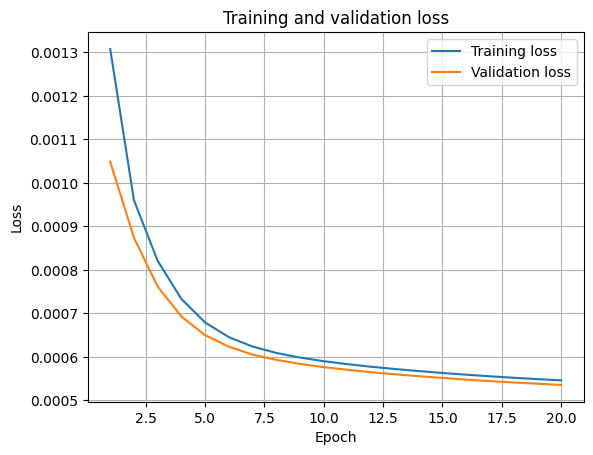

In [18]:
import matplotlib.pyplot as plt

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

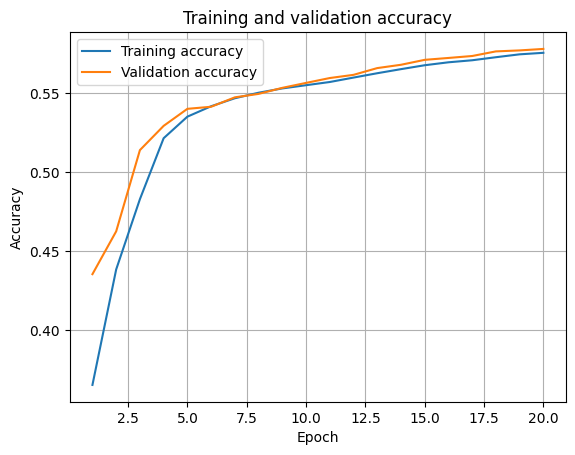

In [19]:
import matplotlib.pyplot as plt

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

#### RNN Version 2

We will train the same RNN with only one change: the loss function is now  `cosine similarity`. This change should help the RNN to return more similar vectors in their direction as focusing on the exact values of the output vector. This loss function could return a value in [-1, 1]. As documented in [Keras](https://keras.io/api/losses/regression_losses/#cosinesimilarity-function), 0 indicates orthogonality and a value close to -1 indicate greater similarity between two vectors. The best loss value should be here close to -1.

##### Training the model

We train this model with the same training, validation and test data as for RNN 1: 

In [20]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger

# Build the model
embedding_dim = X_playlists_train.shape[2] # 300

model2 = Sequential()
model2.add(LSTM(128, input_shape=(playlist_max_len, embedding_dim)))
model2.add(Dense(embedding_dim, activation='tanh'))
model2.compile(optimizer='rmsprop', loss='cosine_similarity',
              metrics=['accuracy'])
model2.summary()

# Train the model
epochs = 20
batch_size = 128
csv_logger = CSVLogger('training_2.log', separator=',', append=False)

history2 = model2.fit(X_playlists_train, y_playlists_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_data=(X_playlists_val, y_playlists_val),
                    verbose=1, callbacks=[csv_logger])

# Evaluate the model
score2 = model2.evaluate(X_playlists_test, y_playlists_test, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 300)               38700     
                                                                 
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
572/572 [==============================] - 16s 25ms/step - loss: -0.9053 - accuracy: 0.5764 - val_loss: -0.9208 - val_accuracy: 0.5970
Epoch 2/20
572/572 [==============================] - 14s 24ms/step - loss: -0.9200 - accuracy: 0.5983 - val_loss: -0.9195 - val_accuracy: 0.5873
Epoch 3/20
572/572 [==============================] - 13s 23ms/step - loss: -0.9209 - accuracy: 0.6021 - val_loss: -0.9219 - val_accuracy: 0.6031
Epoch 

We get here a loss value close to - 1, meaning that predicted vectors and expected vectors are similar in term of direction in the vector space. This means that predictions are similar in term of what our computed track embeddings has defined as similar tracks.

##### Evolution of loss and accurancy

The loss value often vary here on the validation data but still remain really close to -1.

In [23]:
# if the model was trained in the current session:
history_dict_2 = history2.history

In [35]:
# load history from saved model:
import pandas as pd
history_dict_2 = pd.read_csv('training_2.log', sep=',', engine='python')

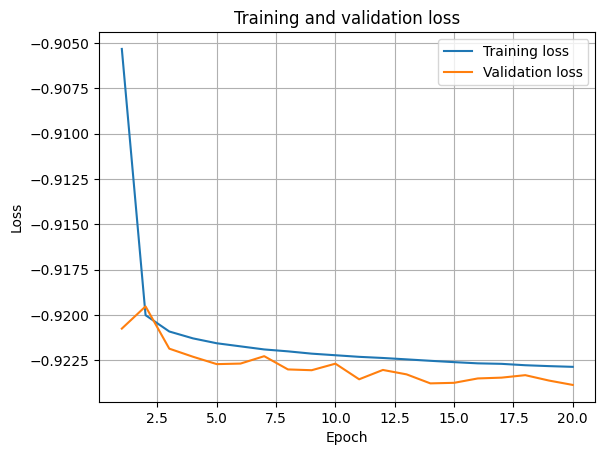

In [25]:
import matplotlib.pyplot as plt

train_loss = history_dict_2['loss']
val_loss = history_dict_2['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

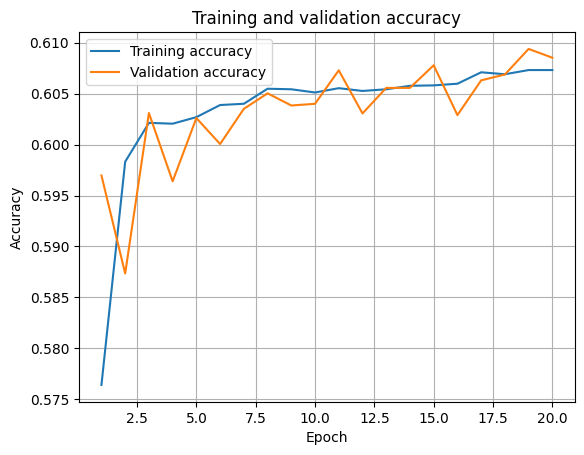

In [26]:
import matplotlib.pyplot as plt

train_acc = history_dict_2['accuracy']
val_acc = history_dict_2['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Save and load the models

In [27]:
model.save('models/spotify_playlist.h5')

In [28]:
model2.save('models/spotify_playlist_2.h5')

In [14]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
model = load_model('models/spotify_playlist.h5')

if model:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________


In [15]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
model2 = load_model('models/spotify_playlist_2.h5')

# Show the models architectures
if model2:
    model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 300)               38700     
                                                                 
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________


We can now defined a helper method for generated a playlists based on a window of 10 tracks.

In [16]:
# exec on every opening
from keras.models import Sequential

embedding_dim = 300 

def __predict_next_track(song_uris: list[str], model: Sequential ) -> str:
    """Predict the next possible song with help of the selected RNN."""
    x = np.zeros((1, playlist_max_len, embedding_dim))
    embedded_songs = [ convert_track_to_vec(song_uri) for song_uri in song_uris]
    x[0] = np.array([embedded_songs])

    next_song = model.predict(x, verbose=0)[0]

    return convert_vec_to_track(np.asarray(next_song).astype('float64'))

def predict_next_song(song_uris: list[str]) -> str:
    """Predict the next possible song with help of a RNN. Needs one or more windows of 10 song_uris as input. This method uses RNN 1."""
    if not model:
        raise AssertionError("The model isn't loaded.")

    return __predict_next_track(song_uris, model)

def predict_next_song_v2(song_uris: list[str]) -> str:
    """Predict the next possible song with help of a RNN. Needs one or more windows of 10 song_uris as input. This method uses RNN 2."""
    if not model2:
        raise AssertionError("The model 2 isn't loaded.")

    return __predict_next_track(song_uris, model2)

In [17]:
playlists = pd.read_json(playlists_filename)
song_uris = [song['track_uri'] for song in playlists.iloc[1]['tracks'][1:11]] # need 10 tracks
print(f"expected y: { playlists.iloc[1]['tracks'][11]['track_uri']}, RNN 1: {predict_next_song(song_uris)}, RNN 2: {predict_next_song_v2(song_uris)}")

song_uris = [song['track_uri'] for song in playlists.iloc[5]['tracks'][1:11]] # need 10 tracks
print(f"expected y: { playlists.iloc[5]['tracks'][11]['track_uri']}, RNN 1: {predict_next_song(song_uris)}, RNN 2: {predict_next_song_v2(song_uris)}")

song_uris = [song['track_uri'] for song in playlists.iloc[60]['tracks'][10:20]] # need 10 tracks
print(f"expected y: { playlists.iloc[60]['tracks'][20]['track_uri']}, RNN 1: {predict_next_song(song_uris)}, RNN 2: {predict_next_song_v2(song_uris)}")

expected y: spotify:track:4TTV7EcfroSLWzXRY6gLv6, RNN 1: spotify:track:0mFyq7zeU21fW5VE9028lN, RNN 2: spotify:track:2XUMDFZUpqO0vaRuEgvCFO
expected y: spotify:track:12lZTPlXwUtrQuhEty6098, RNN 1: spotify:track:3qK8x4GZcIkzTz9JEqvIF5, RNN 2: spotify:track:3qK8x4GZcIkzTz9JEqvIF5
expected y: spotify:track:4Uiw0Sl9yskBaC6P4DcdVD, RNN 1: spotify:track:6VdGDiy7V3j9LqfC5E1Uvi, RNN 2: spotify:track:4T3fEhOYsYTwtxzA7TQBkf


| test playlist | expected track | RNN 1 result | RNN 2 result |
|-----------|-----------|-----------|-----------|
| 1 | Alexander Hamilton from Leslie Odom Jr. | Princess Leia's Theme by John Wiliams | At the Ballet by Marvin Hamlisch |
| 2 | Raise tour glass by P!nk | Let's Get it started - Spike mix by Black Eyed Peas | same track as RNN 1 |
| 3 | Be Quiet And Drive (Far Away) by Deftones | Son's Gonna Rise by Citizen Cope | This is your life by The Killers |

The models will be evaluated in the next section with best pratices, these three playlists were only used for testing the RNNs and seeing if everything is working well.

Sometimes the RNNs could return the same tracks as here with the second test playlist. A possible reason is that they have similar architectur and were trained with the same track embeddings and training data. Returned tracks for test one have all a simmilary style in comparation to the expected track. In test two, Raise tour glass and Let's Get it started are tracks with high ernergy and could fit together in a playlist. Finally, Tracks from 3th test are also similar in their style or genre.
It is complexe to evaluate the two RNNs, when looking on the returned tracks. Indeed, tracks for the first test are from the same film, even if the artirts were different. In the second test, both RNNs returned exactly the same track or the convertion from vector to track uri has led to the same track.

### Free data

In [17]:
# free ram
del X_playlists_train
del y_playlists_train
del X_playlists_val
del y_playlists_val
del X_playlists_test
del y_playlists_test

## <span style="color:green">Evaluation of each method</span>

We will need to split our test data with track uris into lists of K-gramms. The methods to test:
- 2 baseline methods: These methods will be helpfull to evaluation our trained models and to define a lower and upper bound.
    - `get_random_song`: this method should have a bad score, as their is a chance of $\frac{1}{|tracks|}$ to pick a valid song according to our first evaluation case. For the next two cases, the chance could be greather, but it will remain very low. As a consequence, our three advanced methods should be better than this first beline method.
    - `get_next_song`: this method needs to go throutgh each playlist, but should have a better score than the random method. As our tests has already shown, the next track is not always the real next one in the playlist. Additioanally, with an unseen combination of tracks the returned value could be None.
- 3 advanced methods: These methods should always return a track, even for an unseen combination of input tracks.
    - `get_next_similar_song`: this method use the computed Word2Vec embedding model and cosinus similarity to pick the next song. This method is more flexible than `get_next_song` for unseen combination of tracks.
    - `predict_next_song`: this method use the first RNN, which was trained with the track embeddings and MSE as loss function.
    - `predict_next_song_v2`: this method use the second RNN, which was trained with the track embeddings and cosine similarity as loss function.

We will use the precision as metric for our evaluations. As reminder: $Precision = \frac{\#TP}{\#TP + \#FP}$

Evaluations to perform:
- Evaluation 1: Given the k previous songs, the predicted songs has to be the direct next one.
- Evaluation 2: given k songs, the predicted song has to occur in the same playlist after these k songs.
- Evaluation 3: given k songs, the predicted song should have a common album or artist with the next possible songs, or to occur in the same playlist after these k songs.
- Finally, we will test unseen combinations with three self-made playlists and make a small user study for evaluating the three advanced methods: track embeddings and the two RNNs. This evaluation will take the form of a google form. 

As the evaluation of each method could take a lot of time, we added the progression bar from tqdm to have a visual estimation of the progression.

In [18]:
# exec on every opening
import pandas as pd

# reload tracks and playlists for baseline methods (freed while training the RNN)
tracks = pd.read_json(tracks_filename)
playlists = pd.read_json(playlists_filename)

# test data for evaluation of baseline methods -> 20% of the 20,000 playlists
X_test_baseline, y_test_baseline = playlists_k_gram(playlists_test_baseline, playlist_max_len, step)

### Evaluation 1: exactly the next track

In this first sessions of evaluations, we will computre the precision of each 4 methods on our computed test k gramms.

In [19]:
# exec on every opening
from typing import Callable
from tqdm import tqdm

def eval_method(X: list[list[str]],
                y: list[str],
                method: Callable[[list[str]], str|None]) -> dict[str, int]:
    """Simple evalution method for playlist generation: check if predicted track is the expected next track"""
    score = {
        'true': 0,
        'total': len(X)
    }
    
    for index in tqdm(range(len(X))):
        next_song = method(X[index])
        if next_song == y[index]:
            score['true'] += 1
            
    return score

#### Random baseline method

In [39]:
score = eval_method(X_test_baseline, y_test_baseline, get_random_next_song)
print(f'random: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [02:23<00:00, 172.67it/s]

random: {'true': 0, 'total': 24770}, Precision: 0.0


#### Second baseline method with tracks occurences

In [40]:
score = eval_method(X_test_baseline, y_test_baseline, get_next_song)
print(f'table scan: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [1:13:43<00:00,  5.60it/s]

table scan: {'true': 18789, 'total': 24770}, Precision: 0.75853855470327


#### Track2Vec embedding with cosine similarity

In [41]:
score = eval_method(X_test_baseline, y_test_baseline, get_next_similar_song)
print(f'track2vec and cosine similarity: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [08:05<00:00, 51.02it/s]


track2vec and cosine similarity: {'true': 130, 'total': 24770}, Precision: 0.005248284214775939


#### RNN 1 with MSE

In [19]:
score = eval_method(X_test_baseline, y_test_baseline, predict_next_song)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [26:29<00:00, 15.58it/s]

neural network with LSTM: {'true': 26, 'total': 24770}, Precision: 0.0010496568429551878


### RNN 2 with cosine simularity

In [20]:
score = eval_method(X_test_baseline, y_test_baseline, predict_next_song_v2)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [26:03<00:00, 15.84it/s]

neural network with LSTM: {'true': 50, 'total': 24770}, Precision: 0.0020185708518368995


Scores of all 4 methods:

| method            | true positive | Precision |
|-------------------|---------------|-----------|
| random            | 0      |  0%    |
| track occurrances | 18,789 | 75.85% |
| track2vec         | 130    |  0.52% |
| RNN 1             | 26     |  0.10% |
| RNN 2             | 50     |  0.20% |

We see that even with $\frac{1}{|tracks|}$ of chance, the random baseline method isn't good at predicting the next track.

Precisions for track2vec and for the trained model are also very low. A possible reason is that maybe strictly getting the next track is not a simple tacks and that other tracks in the whole playlists are more similiar or occur more often together. One important point is that the embedding alone has a better precision than the two RNNs. One explanation could be that two vectors with a really small MSE or cosine similarity could lead to two different track uris. Indedd, it is possible taht the returned vector doesn't perfectly fit a vector of the computed embedding, so that the Word2Vec model will returned another track uri, which vector representation is really close to the expect track uri. The embedding model will always return a vector that correspond to an existing track. Finally RNN 1 and RNN 2 have a realy close result, so that we can't say if RNN 2 is really better than RNN 1.

The method `get_next_song` has a precision of 75.85%, which is higher than the four other methods, but has a high computation time of more than one hour. We cleary see, that we will probabely not do better than this baseline, when using our three trained models.

### Evaluation 2: returned track occurs after the k initial tracks

Based on the results of the first strict evaluation, it was required to introduce more flexibility in the evaluation task.
As second evaluation method, we will check if the returned track in contained in the initial palylist after the k initial tracks. So we have to check if the returned track occurs after the initial k tracks of the playlist.

In [20]:
# exec on every opening
import pandas as pd
from typing import Callable
from tqdm import tqdm

def is_contained_eval_method(X: list[list[str]],
                             y: list[list[str]],
                             method: Callable[[list[str]], str|None]) -> dict[str, int]:
    """Evalution method for playlist generation: check if predicted track is in possible_next_songs."""
    score = {
        'true': 0,
        'total': len(X)
    }
    
    for index in tqdm(range(len(X))):
        next_song = method(X[index])
        
        if next_song in y[index]:
            score['true'] += 1
            
    return score

def extended_playlist_k_gram(tracks: list[str], k: int, step: int = 1) -> tuple[list[list[str]], list[list[str]]]:
    """Split a list of tracks in k grams: X[i] contains a sequence of k tracks, y[i] the tracks after these k tracks."""
    X: list[list[str]] = []
    y: list[list[str]] = []
        
    for i in range(0, len(tracks) - k, step):
        X.append(tracks[i:i+k])
        y.append(tracks[i+k:])
    
    return X, y

def extended_playlists_k_gram(playlists: pd.Series, k: int, step: int = 1) -> tuple[list[list[str]], list[list[str]]]:
    """Split the list of playlists in k grams: X[i] contains a sequence of k tracks, y[i] the tracks after these k tracks."""
    X: list[list[str]] = []
    y: list[list[str]] = []
        
    for playlist in playlists:
        playlist_x, playlist_y = extended_playlist_k_gram(playlist, k, step)
        X.extend(playlist_x)
        y.extend(playlist_y)
    
    return X, y


In [21]:
# exec on every opening
X_test_baseline, y_test_baseline_2 = extended_playlists_k_gram(playlists_test_baseline, playlist_max_len, step)

#### Random method

In [172]:
score = is_contained_eval_method(X_test_baseline, y_test_baseline_2, get_random_next_song)
print(f'random: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [02:17<00:00, 179.53it/s]

random: {'true': 4, 'total': 24770}, Precision: 0.00016148566814695197


#### Second baseline method with tracks occurences

In [31]:
score = is_contained_eval_method(X_test_baseline, y_test_baseline_2, get_next_song)
print(f'With tracks occurences: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [1:07:44<00:00,  6.09it/s]

table scan: {'true': 24736, 'total': 24770}, Precision: 0.9986273718207509


#### Track2Vec embedding with cosine similarity

In [173]:
score = is_contained_eval_method(X_test_baseline, y_test_baseline_2, get_next_similar_song)
print(f'track2vec and cosine similarity: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [07:36<00:00, 54.29it/s]

track2vec and cosine similarity: {'true': 1188, 'total': 24770}, Precision: 0.04796124343964473


#### RNN 1 with MSE

In [23]:
score = is_contained_eval_method(X_test_baseline, y_test_baseline_2, predict_next_song)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [26:41<00:00, 15.47it/s]

neural network with LSTM: {'true': 328, 'total': 24770}, Precision: 0.01324182478805006


### RNN 2 with cosine simularity

In [24]:
score = is_contained_eval_method(X_test_baseline, y_test_baseline_2, predict_next_song_v2)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [26:30<00:00, 15.57it/s]  

neural network with LSTM: {'true': 597, 'total': 24770}, Precision: 0.02410173597093258


Scores of all 4 methods:

| method            | true positive | Precision |
|-------------------|---------------|-----------|
| random               | 4      |  0.01% |
| track occurrences    | 24,736 | 99.86% |
| track2vec            | 1,188  |  4.80% |
| RNN 1 with MSE       | 328    |  1.32% |
| RNN 2 with cos. sim. | 597    |  2.41% |

As supposed precision of all 4 methods are better, as the evaluation is more flexible. Except for `get_next_song` the precision remains low, under 5%, which is not a good result. On the other side, the precision of `get_next_song` is above 99%. 

The track embeddings remains slightly better than two trained RNNs, maybe because of the loss of precission when converting the returned vector to an existing track uri. Here RNN 2 has a better score, but the difference with RNN 1 is only of 1.09%.

For the random method, the number of true positive may change or vary a lot in each run. We firstly had 10 true positive, but the probability is really low to have a precision above 1% with this method.

### Evaluation 3: returned track is similar to the next tracks

In this last evaluation session, we will evaluate if the returned track is similar to the possibles next tracks of the initial playlist. By similuar we mean a common artirst or album. We still count as true if the returned track occurs after the k initial tracks. This test case extends the second one, so we expect at least the same values for each methods. Exception for the random method, as it could be better or worst.

In [22]:
# exec on every opening
import pandas as pd
from typing import Callable
from tqdm import tqdm

def same_values(pred_track_uri: str | None, possible_next_tracks: pd.DataFrame) -> bool:
    """Check if predicted track is in possible_next_songs or has a common artist or album as possible_next_songs."""
    if not pred_track_uri: # pred_track_uri could be none
        return False
    if possible_next_tracks['track_uri'].isin([pred_track_uri]).any():
        return True
    
    pred_track = tracks.loc[tracks.index == track2number[pred_track_uri]]

    return (pred_track['artist_uri'].isin(possible_next_tracks['artist_uri']).any() or
            pred_track['album_uri'].isin(possible_next_tracks['album_uri']).any())


def same_values_eval_method(X: list[list[str]],
                            y: list[pd.DataFrame],
                            method: Callable[[list[str]], str|None]) -> dict[str, int]:
    """Evalution method for playlist generation: check if predicted track is in possible_next_songs or has a common artist or album as possible_next_songs."""
    score = {
        'true': 0,
        'total': len(X)
    }
    
    for index in tqdm(range(len(X))):
        next_song = method(X[index])
        
        if same_values(next_song, y[index]):
            score['true'] += 1
            
    return score

We need to get artist_uri and album_uri for every tracks in y_test_baseline in order to perform this evaluation. We use track2number to archive better speed execution:

In [23]:
y_test_track_numbers = [[ track2number[track_uri] for track_uri in track_uris] for track_uris in y_test_baseline_2]
y_test_baseline_extended = [ tracks.loc[tracks.index.isin(next_song_uris)] for next_song_uris in y_test_track_numbers]
del y_test_track_numbers

#### Random method

In [105]:
score = same_values_eval_method(X_test_baseline, y_test_baseline_extended, get_random_next_song)
print(f'random: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [02:28<00:00, 166.28it/s]

random: {'true': 155, 'total': 24770}, Precision: 0.006257569640694388


#### Second baseline method with tracks occurences

In [29]:
score = same_values_eval_method(X_test_baseline, y_test_baseline_extended, get_next_song)
print(f'With tracks occurences: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [1:06:46<00:00,  6.18it/s]

With tracks occurences: {'true': 24742, 'total': 24770}, Precision: 0.9988696003229713


#### Track2Vec embedding with cosine similarity

In [177]:
score = same_values_eval_method(X_test_baseline, y_test_baseline_extended, get_next_similar_song)
print(f'track2vec and cosine similarity: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [07:56<00:00, 52.03it/s]

track2vec and cosine similarity: {'true': 5220, 'total': 24770}, Precision: 0.2107387969317723


#### RNN 1 with MSE

In [24]:
score = same_values_eval_method(X_test_baseline, y_test_baseline_extended, predict_next_song)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [25:41<00:00, 16.06it/s]

neural network with LSTM: {'true': 3211, 'total': 24770}, Precision: 0.12963262010496568


### RNN 2 with cosine simularity

In [25]:
score = same_values_eval_method(X_test_baseline, y_test_baseline_extended, predict_next_song_v2)
print(f'neural network with LSTM: {score}, Precision: {score["true"]/score["total"]}')

100%|██████████| 24770/24770 [25:42<00:00, 16.06it/s] 

neural network with LSTM: {'true': 4275, 'total': 24770}, Precision: 0.1725878078320549


Scores of all 4 methods:

| method            | true positive | Precision |
|-------------------|---------------|-----------|
| random               | 155    |   0.63% |
| track occurrences    | 24,742 | 99.89% |
| track2vec            | 5,220  | 21.07% |
| RNN 1 with MSE       | 3,211  | 12.96% |
| RNN 2 with cos. sim. | 4,275  | 17.26% |

The baseline method `get_next_song` remains the best method for this evaluation case. But we see here an increased of the precison for the track embedding and RNN with a factor of 5, which is far better than is the two strict evaluation cases. Moreover, these results remains really low. The track embedding remains better than two RNNs, as already seen in the two other evaluations. RNN 2 is slightly better than RNN 1 in this evaluation session with a difference of 5%. Finally, the random method is cleary the worst method for predicting the next tracks.

### Results of all 3 evaluations sessions:

We will now discuss about the three evaluations for each methods:

| method / Precision| Exactly the next track | Returned track occurs after the k tracks | Returned track is similar to the next tracks
|-------------------|---------------|-----------|-----------|
| random               |  0%    | 0.01%  | 0.63%  |
| track occurrences    | 75.85% | 99.86% | 99.89% |
| track2vec            |  0.52% |  4.80% | 21.07% |
| RNN 1 with MSE       |  0.10% |  1.32% | 12.96% |
| RNN 2 with cos. sim. |  0.20% |  2.41% | 17.26% |

Note: each evaluation case is an extention of the previous one with more flexibilty. That's the reason why we always get higher values for the precison. Last evaluation is far more flexible than the first one.

We see that in each case the baseline method `get_next_song` with the analysis of track occurences is far better than all other methods. This method could be seen as an upper bound or the best possible method for predicting a relevant next song. Moreover, this method a huge processing time on a large amount of data. It's possible that this method has sometime returned a None value, but this case was treated as false postive. In other words, this methods desn't always return a track and is less flexible than the other evaluated methods. These could be one of the reasons why we don't get 100%. Another reason was already seen when testing on the first playlist: sometimes tracks with most occurences aren't in the expected next tracks on the current playlist.

Our three trained methods have relatively small precision. Even with the more flexible evaluation case 3, the precision remain under 22% which is still a bad score. One positive point is that our methods are far better than the random method, which the lower bound to strike. So at least, our methods are far better than randomness. The trained track2Vec model has in all three cases a better precision than the two RNNs, but precisions are still close with "only" a maximal difference of 4% with RNN 2. There are small differences between the two trained RNNs when we compare the precision. The RNN 2 with cosine similarity seems to be slightly better than RNN 1 with MSE. Predicting a vector with a similar direction seems to be better than attempting to have a vector with close values in comparation to the expected vector. As they have a similar architecture and expect the same track embeddings, their prediction could be in some cases really close or eventually the same.

### User study with unseen combination of tracks

As last evaluation, we will use our three developed methods (track embedding and the two RNNs) and define three initial playlists of 10 similar tracks. We will focus on unseen combination of tracks, which is impossible to solve with the baseline method `get_next_song`. Moreover, this particular task is complex to evaluate through a function like for the three other evaluation cases, so that we decide to define a small user study. Given three playlists of 10 tracks, this three models will attempt to find a good next song.

We then made a google form with 3 pages, one for each tested playlist. Each Page will first show the 10 initial songs and after that the 2 or three suggestions (depending on models outputs). User will have to note for each playlist the three suggestions with a grade between 0 (not similar) to 10 (similar / same style or genre). It's some kind of suggestive.

#### Playlists to test

Our user study will be based on theese three selfmade playlists. The first two playlists contains most similar tracks, but the last one contains tracks with and without lyrics as well as different genres or styles. The results of this last playlist could be very interresting, as it will analyse a more complexe context.

##### Playlist one

| track id | name | artist | album |
|-----------|-----------|-----------|-----------|
| 2HHtWyy5CgaQbC7XSoOb0e | Eye of the tiger    | Survivor | Eye of the tiger |
| 4BFMQ15vXr626UOoZL8bUI | The time of my life | Bill Medley | Platinium & Gold Collection |
| 3MrRksHupTVEQ7YbA0FsZK | The final countdown | Europe | The final countdown (Expanded edition) |
| 1hZJcuz9iMoz6tLkFlIaUy | Take my breath away | Berlin | Take my breath away |
| 3YKptz29AsOlm7WAVnztBh | Kiss from a rose    | Seal | Seal |
| 0rTkE0FmT4zT2xL6GXwosU | I got You (I feel good) | James Brown & The Famous Flames | I got You (I feel good) |
| 6wjSNO6uJYlgbbfauyWhiw | Wind of Change | Scorpions | Crazy world |
| 49zeNqC8dkKofXLqG9kFTr | The power of love | Huey Lewis & The news | Collected |
| 1xPSDf8z4dH46gkvlLtvDO | Maniac | Michael Sembello | Flashdance Original Soundtrack From The motion Picture |
| 1qyJ6XpMHdsJD8pkiA7Qww | We don't need Another hero | Tina Turner | Simply the Best |

##### Playlist two

| track id | name | artist | album |
|-----------|-----------|-----------|-----------|
| 21mnS0J0H0ZZsw32MRZa9a | Animals - UK Radio Edit  | Martin Garrix | Animals |
| 5B03nSG8pLE48jh7kmasuL | Levels - Radio Edit  | Avicii | True |
| 6TbYnMMWfdUZXQm6tZ6vib | Rock N' Roll [Will Take You To The Mountain]  | Skrillex | Scary Monsters And Nice Sprites |
| 6VmCNmp0LeKvZWV3PQQyna | If Only I Could - Radio Edit  | Brooks | If Only I Could |
| 1zIEwDU2IZyHjy17ssOvyr | Save the World  | Swedish House Mafia | Until Now |
| 14eqkkICgX9BTqL8qykxJ7 | Emergency  | Pegboard Nerds | Emergency |
| 6A5nHAuwsuanT3uEMAouxF | Afterglow  | Wilkinson | Lazers Not Included |
| 0a9wk9ZCwe0ONEyBXXsNpE | Secrets - Radio Edit  | Tiësto | A Town Called Paradise |
| 0TxMRiAvI1s0L821BJJWzx | Around The World - Radio Edit  | Daft Punk | Musique Vol 1 |
| 7m47Go71qTMBs4kTH7U8F8 | Pursuit Of Happiness - Extended Steve Aoki Remix (Explicit)  | Kid Cudi | Pursuit Of Happiness |

##### Playlist three

| track id | name | artist | album |
|-----------|-----------|-----------|-----------|
| 01ICFoBoco3TaM5r3HthXy | Master of puppets | Metallica | Master of puppets (Remastered) |
| 1BncfTJAWxrsxyT9culBrj | Experience | Ludovico Einaudi | In a time lapse |
| 3zYufmyv6HOuiHn1eMR6Ja | Desert rose  | Sting | Brand new day |
| 1kNIJEfefBtOAT7aKdEyIn | This is Gallifrey: our childhood. Our home  | Murray Gold | Doctor Who - Series 3 |
| 6xy6jNeNTYwjnKTDzMyHw2 | Zombie | The Cranberries | No need to argue |
| 7di1zbwgfJkRLkTGV44icu | Duel of the fates | London Voices | Star Wars: The phantom menace |
| 6ZFbXIJkuI1dVNWvzJzown | Time | Hanz Zimmer | Inception |
| 4uLU6hMCjMI75M1A2tKUQC | Never gonna give you up | Rick Astley | Whenever you need somebody |
| 4v6jydWBTAIqnyPVNyOAdc | What is love | Haddaway | The album |
| 2gaZJDgE71VL9PzzUUlpMg | Dragonborn  | Jeremy Soule | The elder scrolls V: Skyrim |

In [20]:
from typing import Callable

def get_track_uri(id: str) -> str:
    """Convert the song id to a valid track uri"""
    return f'spotify:track:{id}'

def generate_track_suggestion(song_uris: list[str], methods: list[Callable[[list[str]], str|None]]) -> list[str | None]:
    """Execute defined methods to generate suggestions for the next track of the playlist."""
    result: list[str | None] = []

    for method in methods:
        result.append(method(song_uris))
    
    return result

song_ids_one = ['2HHtWyy5CgaQbC7XSoOb0e', '4BFMQ15vXr626UOoZL8bUI', '3MrRksHupTVEQ7YbA0FsZK', '1hZJcuz9iMoz6tLkFlIaUy', '3YKptz29AsOlm7WAVnztBh', 
                           '0rTkE0FmT4zT2xL6GXwosU', '6wjSNO6uJYlgbbfauyWhiw', '49zeNqC8dkKofXLqG9kFTr', '1xPSDf8z4dH46gkvlLtvDO', '1qyJ6XpMHdsJD8pkiA7Qww']
song_ids_two = ['21mnS0J0H0ZZsw32MRZa9a','5B03nSG8pLE48jh7kmasuL','6TbYnMMWfdUZXQm6tZ6vib','6VmCNmp0LeKvZWV3PQQyna','1zIEwDU2IZyHjy17ssOvyr',
                           '14eqkkICgX9BTqL8qykxJ7','6A5nHAuwsuanT3uEMAouxF','0a9wk9ZCwe0ONEyBXXsNpE','0TxMRiAvI1s0L821BJJWzx','7m47Go71qTMBs4kTH7U8F8']
song_ids_three = ['01ICFoBoco3TaM5r3HthXy', '1BncfTJAWxrsxyT9culBrj', '3zYufmyv6HOuiHn1eMR6Ja', '1kNIJEfefBtOAT7aKdEyIn', '6xy6jNeNTYwjnKTDzMyHw2',
                             '7di1zbwgfJkRLkTGV44icu', '6ZFbXIJkuI1dVNWvzJzown', '4uLU6hMCjMI75M1A2tKUQC', '4v6jydWBTAIqnyPVNyOAdc', '2gaZJDgE71VL9PzzUUlpMg']

test_playlists = [ [get_track_uri(song_id) for song_id in song_ids ] for song_ids in [song_ids_one, song_ids_two, song_ids_three] ]

## Generate the suggestions for each selfmade playlist
for index, playlist in enumerate(test_playlists):
    # the second baseline method can't find a next song, because no playlist contains all tracks in that order
    print(f'Result with tracks occurences for playlist {index + 1}: {get_next_song(playlist)}')
    print(f'Suggestions for playlist {index + 1}: {generate_track_suggestion(playlist, [get_next_similar_song, predict_next_song, predict_next_song_v2])}')

Result with tracks occurences for playlist 1: None
Suggestions for playlist 1: ['spotify:track:5mYtpXrZZ1bbGJYDGC8I0Y', 'spotify:track:7if3aNoVuQUX6WS0np5xLO', 'spotify:track:0odIT9B9BvOCnXfS0e4lB5']
Result with tracks occurences for playlist 2: None
Suggestions for playlist 2: ['spotify:track:5eAWMCaHxKXHh87UsuggdK', 'spotify:track:3BQFSZ786vuUQLrQHCa2Cz', 'spotify:track:2Rn5vJr2DYNcv0hZd646qJ']
Result with tracks occurences for playlist 3: None
Suggestions for playlist 3: ['spotify:track:7AKz0918FbEZOABkxEalur', 'spotify:track:1apyhWqgwJeQV1Bl8ZSApP', 'spotify:track:1apyhWqgwJeQV1Bl8ZSApP']


#### Generated Suggestions

To have a clearer view, we have search on Spotify more data about the suggestions for each test playlists. Users will have to grade all suggestions in the google form.

##### Playlist one
| track id | name | artist | album | model |
|-----------|-----------|-----------|-----------|-----------|
| 5mYtpXrZZ1bbGJYDGC8I0Y | 99 Red Balloons  | NENA    | 99 Luftballons | track embedding |
| 7if3aNoVuQUX6WS0np5xLO | Walk the dinosaur | Was (Not Was) | What up, Dog? | RNN 1 with MSE |
| 0odIT9B9BvOCnXfS0e4lB5 | Bette Davis eyes | Kim Carnes | Mistaken identity | RNN 2 with cos. sim. |

##### Playlist two
| track id | name | artist | album | model |
|-----------|-----------|-----------|-----------|-----------|
| 5eAWMCaHxKXHh87UsuggdK | Apollo (feat. Amba Shepherd) - Original Mix | Hardwell | Apollo (feat. Amba Shepherd) | track embedding |
| 3BQFSZ786vuUQLrQHCa2Cz | Dirty talk - Laidback luke remix | Wynter Gordon | Dirty talk [remixes] | RNN 1 with MSE |
| 2Rn5vJr2DYNcv0hZd646qJ | Trippy | Antiserum | Bangladesh/Trippy | RNN 2 with cos. sim. |

##### Playlist three
| track id | name | artist | album | model |
|-----------|-----------|-----------|-----------|-----------|
| 7AKz0918FbEZOABkxEalur | Addams family theme | Orchestra | The Addams family | track embedding |
| 1apyhWqgwJeQV1Bl8ZSApP | Twilight zone theme | Theatrical music players | Halloween music & sounds | both RNNs |

### Result of study

.....

## <span style="color:green">Conclusion</span>

In this Jupyter notebook several methods of playlists generation were designed and evaluated. We could only use 20,000 of the one millions playlists, because of local hardware limitation or evaluation time, so that possiblely not every tracks from the original database are coverded by our models.

We firstly defined two balise methods, which could be seen as under and upper bound. After that we designed a track embedding thanks to Gensim's Word2Vec model. Based on it, we then trained two recurrent neural networks with diferrent loss functions. At the end, every methods were tested on three criteria. Finally, we made a small user story for evaluating a small amount of generated playlists. We used for generation the embedding model and the two RNN models on unseen combination of tracks.

Our computed models don't achieve a better pression than the second baseline method, but these models are more flexible on unseen combination of tracks and are far faster when used on a large amount of data. The models could be better, if they were training on the whole spotify dataset or with use of data augmentation or overparameters turning.